In [1]:
import pandas as pd 
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
import os

In [2]:
folder_path = '/Users/jonathanquartin/Documents/Coding/GitHub/um_volcano_project/GALAPAGOS_DATA'

In [3]:
# Import tables
precipitation_galapagos = pd.read_csv(os.path.join(folder_path, "precipitation_galapagos.csv"))
climate_bellavista = pd.read_csv(os.path.join(folder_path, "climate_bellavista.csv"))
climate_puerto_ayora = pd.read_csv(os.path.join(folder_path, "climate_puerto-ayora.csv"))
average_galapagos = pd.read_csv(os.path.join(folder_path, "average_galapagos.csv"))
oni = pd.read_csv(os.path.join(folder_path, "oni.csv"))
eruptions = pd.read_csv(os.path.join(folder_path, "eruptions_galapagos.csv"))
rain_by_volc = pd.read_csv(os.path.join(folder_path, "rain_volcs.csv"))

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_34244/713289129.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  precipitation_galapagos = pd.read_csv(os.path.join(folder_path, "precipitation_galapagos.csv"))


In [8]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [204]:
print(oni)

    SEAS    YR  TOTAL  ANOM
0    DJF  1950  24.72 -1.53
1    JFM  1950  25.17 -1.34
2    FMA  1950  25.75 -1.16
3    MAM  1950  26.12 -1.18
4    AMJ  1950  26.32 -1.07
..   ...   ...    ...   ...
879  MAM  2023  27.85  0.16
880  AMJ  2023  28.31  0.48
881  MJJ  2023  28.43  0.77
882  JJA  2023  28.36  1.07
883  JAS  2023  28.28  1.32

[884 rows x 4 columns]


In [206]:
# Converts date information from ONI into numerical format

date_converter = {'DJF': ('12', '03', '01'), 'JFM': ('01', '04', '02'), 'FMA': ('02', '05', '03'), 'MAM': ('03', '06', '04'), 'AMJ': ('04', '07', '05'), 'MJJ': ('05', '08', '06'), 'JJA': ('06', '09', '07'), 'JAS': ('07', '10', '08'), 'ASO': ('08', '11', '09'), 'SON': ('09', '12', '10'), 'OND': ('10', '01', '11'), 'NDJ': ('11', '02', '12')}

def convert_start(row):
    if row['SEAS'] == 'DJF':
        return str(row['YR']-1) + '-' + date_converter[row['SEAS']][0] + '-01'
    else:
        return str(row['YR']) + '-' + date_converter[row['SEAS']][0] + '-01' 

def convert_end(row):
    if row['SEAS'] == 'NDJ':
        return str(row['YR']+1) + '-' + date_converter[row['SEAS']][1] + '-01'
    else: 
        return str(row['YR']) + '-' + date_converter[row['SEAS']][1] + '-01' 

def convert_mid(row):
    return str(row['YR']) + '-' + date_converter[row['SEAS']][2] + '-15' 

oni['Start'] = oni.apply(convert_start, axis=1)
oni['End'] = oni.apply(convert_end, axis=1)
oni['Center'] = oni.apply(convert_mid, axis=1)

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_6969/3237248349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fern_rain['roll'] = fern_rain.Precipitation.rolling(90).mean()


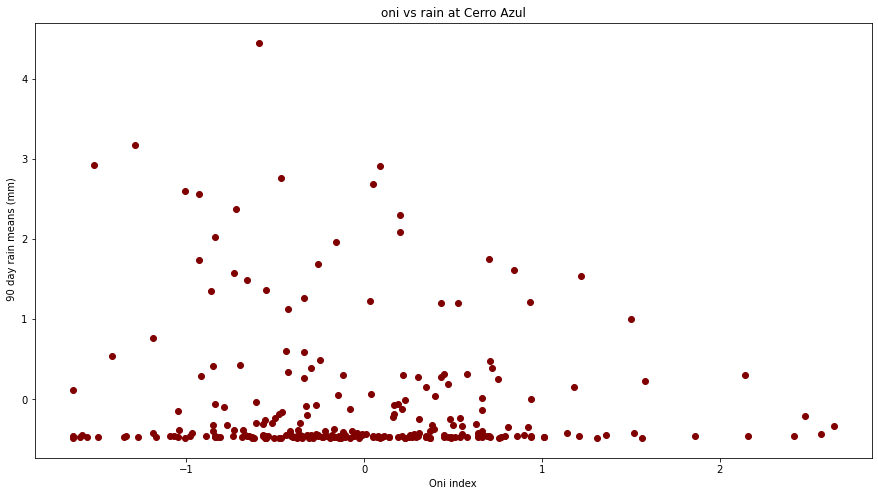

In [257]:
#Compares El Nino data to the precipitation at volcanoes
volcano = 'Cerro Azul'

average = fern_rain.roll.mean()

fern_rain = rain_by_volc[rain_by_volc['Volcano'] == volcano]
fern_rain['roll'] = fern_rain.Precipitation.rolling(90).mean()
merged_df = pd.merge(oni, fern_rain, left_on='End', right_on='Date', how='inner')
merged_df.dropna(inplace=True)
merged_df['Decimal'] = merged_df.Date.apply(date_to_decimal_year)

#merged_df = merged_df[merged_df['Decimal'] % 1 < 0.5]

plt.figure(figsize=(15,8))

plt.scatter(np.array(merged_df['ANOM']), np.array(merged_df['roll']) - average, color ='maroon')

plt.xlabel("Oni index") 
plt.ylabel(" 90 day rain means (mm)") 
plt.title('oni vs rain at ' + str(volcano)) 
# Data plot
plt.show()


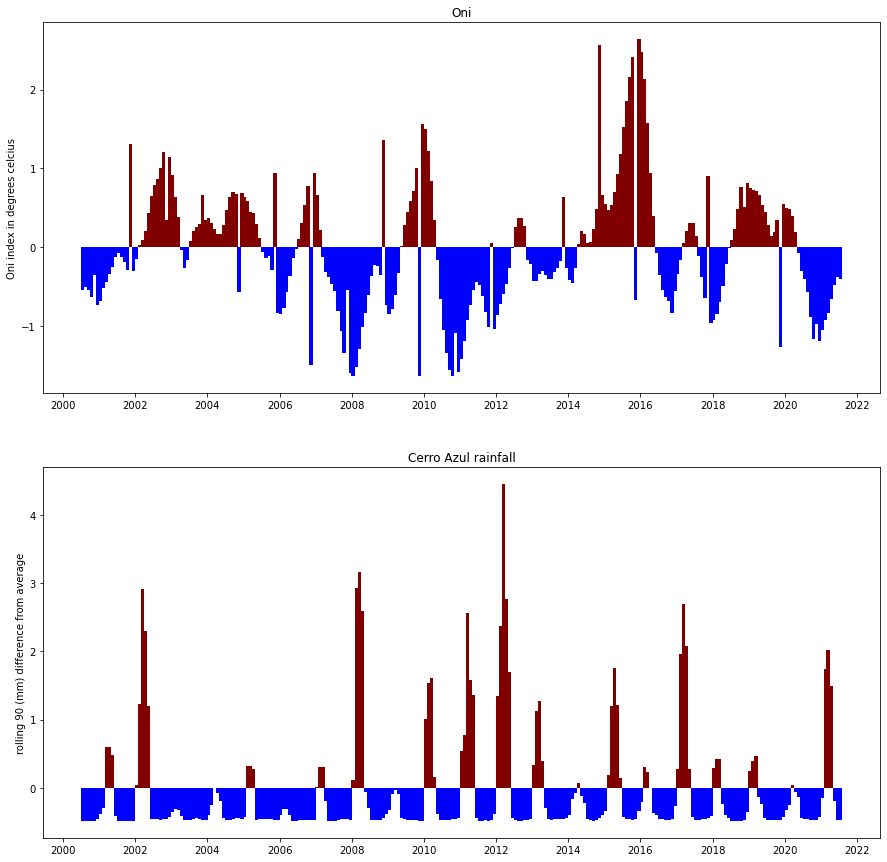

In [258]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15))

colors = ['maroon' if val >= 0 else 'blue' for val in np.array(merged_df['ANOM'])]
axes[0].bar(np.array(merged_df['Decimal'] - .125), np.array(merged_df['ANOM']), color =colors, width = 0.09)
axes[0].set_title('Oni')
axes[0].set_xticks(ticks=[2000 + 2*i for i in range(12)], rotation=90)
axes[0].set_ylabel("Oni index in degrees celcius")
colors = ['maroon' if val >= 0 else 'blue' for val in np.array(merged_df['roll'] - average)]
axes[1].bar(np.array(merged_df['Decimal'] - .125), np.array(merged_df['roll'] - average), color =colors, width = 0.09)
axes[1].set_title(volcano + ' rainfall')
axes[1].set_xticks(ticks=[2000 + 2*i for i in range(12)], rotation=90)
axes[1].set_ylabel("rolling 90 (mm) difference from average")
plt.savefig(str(volcano) + "_oni.jpg")

In [216]:
# Do a regression
X_constants = sm.add_constant(np.array(merged_df['ANOM']))
model_sm = sm.OLS(np.array(merged_df['roll']) - average, X_constants).fit()

r_squared = model_sm.rsquared
print(r_squared)

0.011040636280673422


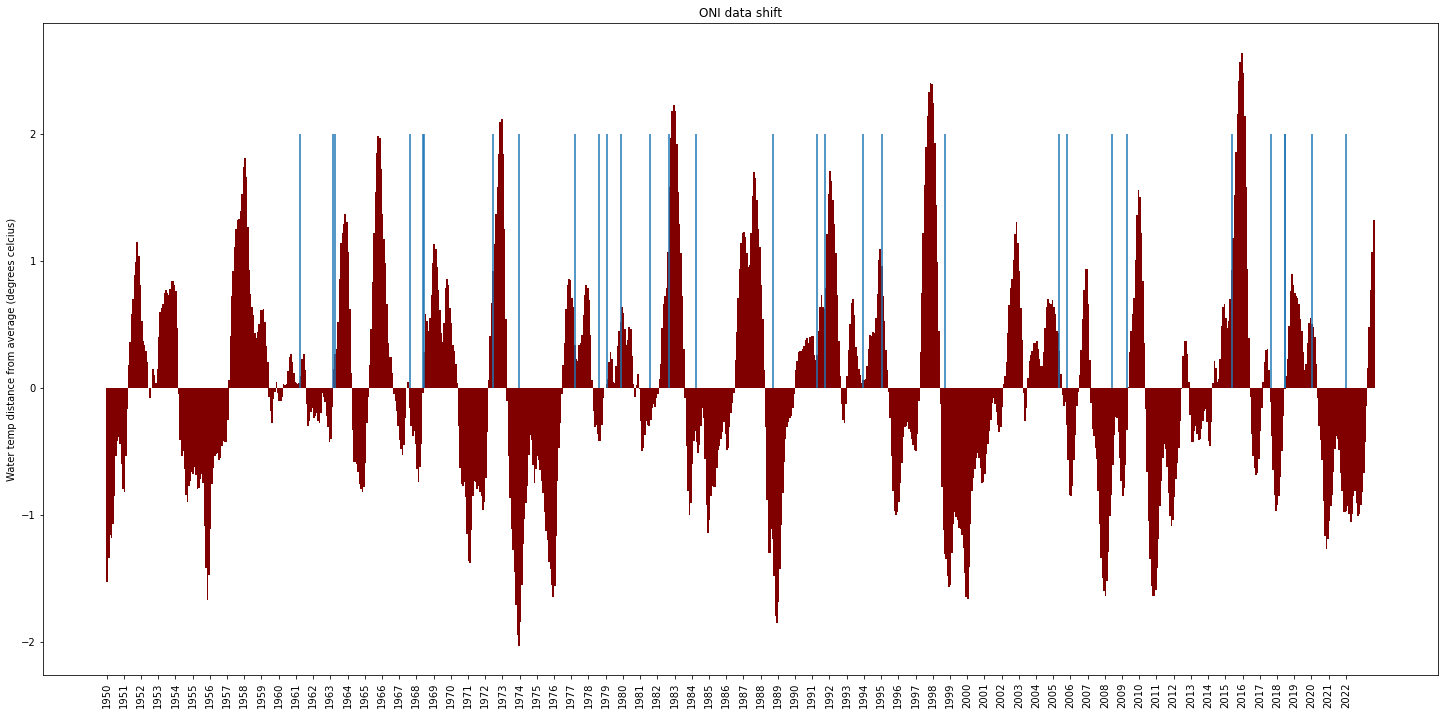

In [7]:
eruption_lines = eruptions['Start'].apply(date_to_decimal_year)

# Convert date strings to decimal years
decimal_year = np.array(oni['Center'].apply(date_to_decimal_year))

plt.figure(figsize=(25,12))

plt.bar(decimal_year, oni['ANOM'], color ='maroon',
       width = 0.1)

plt.vlines(eruption_lines, 0, 2)

plt.ylabel("Water temp distance from average (degrees celcius)")
 
plt.title('ONI data shift')

plt.xticks(ticks=[1950 + i for i in range(73)], rotation=90)

# Data plot
plt.show()

In [47]:
print(climate_puerto_ayora)

      observation_date  min_air_temp  max_air_temp  mean_air_temp  sea_temp  \
0           1964-12-31          22.2          30.8           26.1      25.8   
1           1965-01-01          21.0          25.8           23.9      22.7   
2           1965-01-02          21.1          26.2           23.4      22.4   
3           1965-01-03          22.0          26.6           23.7      23.1   
4           1965-01-04           NaN          26.6           24.0      23.1   
...                ...           ...           ...            ...       ...   
21291       2023-05-06          21.9          31.0           27.2      28.7   
21292       2023-05-07          20.6          31.4           27.0      28.7   
21293       2023-05-08          21.7          30.0           27.3      28.9   
21294       2023-05-09          23.1          29.8           27.1      29.0   
21295       2023-05-10          21.8          29.9           26.8      28.9   

       humidity  precipitation  sunshine_hours  clo

In [4]:
# Pick out columns of interest

#precipitation_bellavista = climate_bellavista[['observation_date', 'precipitation']]
# precipitation_ayora = climate_puerto_ayora[['observation_date', 'precipitation']]
precipitation_ayora = climate_puerto_ayora.copy()
new_era_galapagos = precipitation_galapagos.copy()

In [5]:
print(new_era_galapagos)

                Date Longitude Latitude  Precipitation
0         2000-06-01    -92.45    -2.15          0.000
1         2000-06-01    -92.45    -2.05          0.000
2         2000-06-01    -92.45    -1.95          0.000
3         2000-06-01    -92.45    -1.85          0.000
4         2000-06-01    -92.45    -1.75          0.000
...              ...       ...      ...            ...
19416563  2023-04-30    -87.15     1.65          0.030
19416564  2023-04-30    -87.15     1.75          0.000
19416565  2023-04-30    -87.15     1.85          0.025
19416566  2023-04-30    -87.15     1.95          0.120
19416567  2023-04-30    -87.15     2.05          0.050

[19416568 rows x 4 columns]


In [49]:
# csv_file_name = 'rain_volcs.csv'
# #Fix this so that it doesnt overwrite the header

# column_names = ['Volcano', 'Date', 'Precipitation']

# # Open the CSV file in write mode ('w', 'wb', or 'w+', depending on your Python version).
# with open(csv_file_name, mode='w', newline='') as csv_file:
#     # Create a DictWriter object with the column names.
#     csv_writer = csv.DictWriter(csv_file, fieldnames=column_names)

#     # Write the header (column names) to the CSV file.
#     csv_writer.writeheader()

In [50]:
# # For indiviual volcanoes
# locations = {'Wolf': ('Wolf', 0.0, -91.20), 'Fernandina': ('Fernandina', -0.22, -91.33), 'Sierra Negra': ('Negra, Sierra', -0.83, -91.17), 'Cerro Azul': ('Azul, Cerro', -0.55, -91.24), 'Alcedo': ('Alcedo', -0.26, -91.07), 'Marchena': ('Marchena', 0.35, -90.5), 'Puerto Ayora': ('Puerto Ayora', -0.74, -90.30), 'Bellavista': ('Bellavista', -0.69, -90.33), 'Sierra Negra south coast': ('Negra, Sierra', -1.01, -91.12), 'Sierra Negra south of caldera': ('Negra, Sierra', -0.86, -91.12), 'Sierra Negra north coast': ('Negra, Sierra', -0.65, -91.12)}
# #pick = 'Cerro Azul' # enter desired volcano name here
# lat_range = .2 # enter desired latitude range
# lon_range = .2 # enter desired longitude range
# new_era_galapagos = precipitation_galapagos[precipitation_galapagos['Date'] <= '2021-09-30']
# dates = np.sort(new_era_galapagos['Date'].unique())
# new_era_galapagos['Longitude'] = pd.to_numeric(new_era_galapagos['Longitude'], errors='coerce')
# new_era_galapagos['Latitude'] = pd.to_numeric(new_era_galapagos['Latitude'], errors='coerce')

# for pick in locations:
#     lat = locations[pick][1]
#     lon = locations[pick][2]
#     nearby_rain = new_era_galapagos[(abs(lon - new_era_galapagos['Longitude']) <= lon_range) & (abs(lat - new_era_galapagos['Latitude']) <= lat_range)]
#     for date in dates:
#         rain = nearby_rain['Precipitation'][nearby_rain['Date'] == date].mean()
#         test = {'Volcano': pick, 'Date': date, 'Precipitation': rain}
#         with open('rain_volcs.csv', mode='a', newline='') as main:
#             fieldnames = ['Volcano', 'Date', 'Precipitation']
#             writer = csv.DictWriter(main, fieldnames=fieldnames)
#             writer.writerow(test)

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_85079/2612464224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_era_galapagos['Longitude'] = pd.to_numeric(new_era_galapagos['Longitude'], errors='coerce')
/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_85079/2612464224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_era_galapagos['Latitude'] = pd.to_numeric(new_era_galapagos['Latitude'], errors='coerce')


In [153]:
average_rain = rain_by_volc[rain_by_volc['Volcano'] == 'Fernandina']

print(average_rain)

          Volcano        Date  Precipitation
7792   Fernandina  2000-06-01       0.009024
7793   Fernandina  2000-06-02       0.000276
7794   Fernandina  2000-06-03       0.000000
7795   Fernandina  2000-06-04       0.000000
7796   Fernandina  2000-06-05       0.000000
...           ...         ...            ...
15579  Fernandina  2021-09-26       0.001100
15580  Fernandina  2021-09-27       0.003010
15581  Fernandina  2021-09-28       0.000288
15582  Fernandina  2021-09-29       0.010218
15583  Fernandina  2021-09-30       0.010198

[7792 rows x 3 columns]


In [6]:
# For indiviual volcanoes
locations = {'Wolf': ('Wolf', 0.0, -91.20), 'Fernandina': ('Fernandina', -0.22, -91.33), 'Sierra Negra': ('Negra, Sierra', -0.83, -91.17), 'Cerro Azul': ('Azul, Cerro', -0.55, -91.24), 'Alcedo': ('Alcedo', -0.26, -91.07), 'Marchena': ('Marchena', 0.35, -90.5), 'Puerto Ayora': ('Puerto Ayora', -0.74, -90.30), 'Bellavista': ('Bellavista', -0.69, -90.33), 'Sierra Negra south coast': ('Negra, Sierra', -1.01, -91.12), 'Sierra Negra south of caldera': ('Negra, Sierra', -0.86, -91.12), 'Sierra Negra north coast': ('Negra, Sierra', -0.65, -91.12)}
pick = 'Fernandina' # enter desired volcano name here
lat_range = .2 # enter desired latitude range
lon_range = .2 # enter desired longitude range


lat = locations[pick][1]
lon = locations[pick][2]
new_era_galapagos['Longitude'] = pd.to_numeric(new_era_galapagos['Longitude'], errors='coerce')
new_era_galapagos['Latitude'] = pd.to_numeric(new_era_galapagos['Latitude'], errors='coerce')

nearby_rain = new_era_galapagos[(abs(lon - new_era_galapagos['Longitude']) <= lon_range) & (abs(lat - new_era_galapagos['Latitude']) <= lat_range)]
dates = np.sort(nearby_rain['Date'].unique())
averages = [[date, nearby_rain['Precipitation'][nearby_rain['Date'] == date].mean()] for date in dates]
average_rain = pd.DataFrame(averages, columns = ['observation_date', 'Precipitation'])


In [9]:
# look at unique dates here and convert to decimal. see if decimals all differ by day increments

TypeError: strptime() argument 1 must be str, not numpy.ndarray

In [69]:
# average_rain = average_rain[average_rain['observation_date'] <= '2021-09-30']
# print(average_rain)

In [70]:
# #new_era_bellavista = precipitation_bellavista[(precipitation_bellavista['observation_date'] >= '2000-06-01') & (precipitation_bellavista['observation_date'] < '2014-05-28')]
# #new_era_galapagos = precipitation_galapagos[precipitation_galapagos['Date'] < '2014-05-28']
# new_era_ayora = precipitation_ayora[(precipitation_ayora['observation_date'] >= '2000-06-01') & (precipitation_ayora['observation_date'] <= '2021-09-30')]

In [154]:
#bell_compare = new_era_bellavista.merge(average_rain, on='observation_date', how='inner')
ayora_compare = pd.merge(precipitation_ayora, average_rain, left_on='observation_date', right_on='Date', how='inner')
print(ayora_compare)

     observation_date  min_air_temp  max_air_temp  mean_air_temp  sea_temp  \
0          2000-06-01          22.6          26.0           24.5      24.5   
1          2000-06-02          22.2          26.6           24.5      24.7   
2          2000-06-03          23.5          26.2           24.8      24.6   
3          2000-06-04          23.5          27.4           25.1      24.7   
4          2000-06-05          22.9          27.5           24.7      24.8   
...               ...           ...           ...            ...       ...   
7768       2021-09-26          19.2          24.9           21.9      18.2   
7769       2021-09-27          19.0          25.1           22.1      18.2   
7770       2021-09-28          17.5          25.6           20.7      18.2   
7771       2021-09-29          17.6          24.2           21.1      18.5   
7772       2021-09-30          19.3          24.5           22.5      18.0   

      humidity  precipitation  sunshine_hours  clouds     Volca

In [218]:
ayora = ayora_compare.copy()
ayora['roll_temp'] = ayora['sea_temp'].rolling(90).mean()
ayora['roll_rain'] = ayora['precipitation'].rolling(90).mean()
ayora['roll_volc'] = ayora['Precipitation'].rolling(90).mean()
ayora['roll_humi'] = ayora['humidity'].rolling(90).mean()
ayora['roll_air'] = ayora['mean_air_temp'].rolling(90).mean()
ayora['roll_cloud'] = ayora['clouds'].rolling(90).mean()
ayora['Decimal'] = ayora.Date.apply(date_to_decimal_year)
ayora.dropna(inplace=True)


In [221]:
# Do a regression
ayora_sum = ayora[['roll_cloud', 'roll_temp', 'roll_rain']] #[(ayora['Decimal'] % 1 < .5)]
volcano_sum = ayora['roll_volc'] #[(ayora['Decimal'] % 1 < .5)]

X_constants = sm.add_constant(ayora_sum)
model_sm = sm.OLS(volcano_sum, X_constants).fit()

r_squared = model_sm.rsquared
print(r_squared)

0.7500097973079325


In [183]:
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              roll_volc   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     4155.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:20:47   Log-Likelihood:                -2337.7
No. Observations:                4159   AIC:                             4683.
Df Residuals:                    4155   BIC:                             4709.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4087      0.135     17.875      0.0

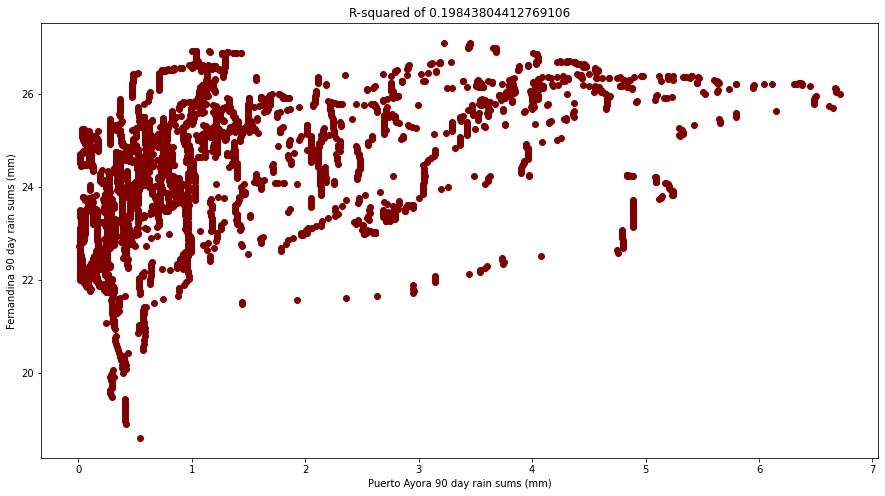

In [119]:
plt.figure(figsize=(15,8))

plt.scatter(ayora_sum, volcano_sum, color ='maroon')

plt.xlabel("Puerto Ayora 90 day rain sums (mm)") 
plt.ylabel(str(pick) + " 90 day rain sums (mm)") 
plt.title('R-squared of ' + str(r_squared)) 
# Data plot
plt.show()

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_53890/1706898902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversed_average_rain['roll_av'] = reversed_average_rain.Precipitation.rolling(91).mean() - average


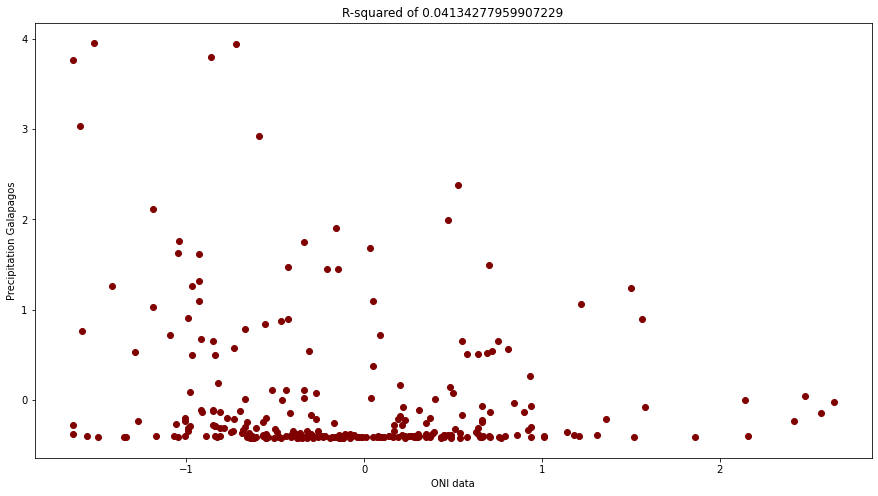

In [49]:
# Performs linear regression on ONI versus Galapagos rainfall data
average = average_rain['Precipitation'].mean()

reversed_average_rain = average_rain.iloc[::-1]
reversed_average_rain['roll_av'] = reversed_average_rain.Precipitation.rolling(91).mean() - average
reversed_average_rain = reversed_average_rain.dropna()
result = pd.merge(oni, reversed_average_rain, left_on='Center', right_on='observation_date', how='inner').sort_values(by=['roll_av'])

x = np.array(result['ANOM'][result['observation_date'] > '2000'])
y = np.array(result['roll_av'][result['observation_date'] > '2000'])
X_constants = sm.add_constant(x)
model_sm = sm.OLS(y, X_constants).fit()

r_squared = model_sm.rsquared

plt.figure(figsize=(15,8))

plt.scatter(x, y, color ='maroon')

plt.xlabel("ONI data") 
plt.ylabel("Precipitation Galapagos") 
plt.title('R-squared of ' + str(r_squared)) 
# Data plot
plt.show()


The statistics are better when we shift rainfall by three months.

In [45]:
print(result)

    SEAS    YR  TOTAL  ANOM       Start         End      Center  \
16   ASO  2001  26.63 -0.19  2001-08-01  2001-11-01  2001-09-15   
15   JAS  2001  26.86 -0.13  2001-07-01  2001-10-01  2001-08-15   
218  JJA  2018  27.38  0.09  2018-06-01  2018-09-01  2018-07-15   
11   MAM  2001  27.25 -0.34  2001-03-01  2001-06-01  2001-04-15   
1    AMJ  2000  27.00 -0.71  2000-04-01  2000-07-01  2000-05-15   
..   ...   ...    ...   ...         ...         ...         ...   
140  DJF  2012  25.77 -0.86  2011-12-01  2012-03-01  2012-01-15   
102  OND  2008  26.12 -0.55  2008-10-01  2008-01-01  2008-11-15   
92   DJF  2008  25.00 -1.64  2007-12-01  2008-03-01  2008-01-15   
91   NDJ  2007  25.02 -1.60  2007-11-01  2008-02-01  2007-12-15   
139  NDJ  2011  25.58 -1.04  2011-11-01  2012-02-01  2011-12-15   

    observation_date  Precipitation   roll_av  
16        2001-11-01       0.000000 -0.421088  
15        2001-10-01       0.000000 -0.420951  
218       2018-09-01       0.000987 -0.420738  
11 

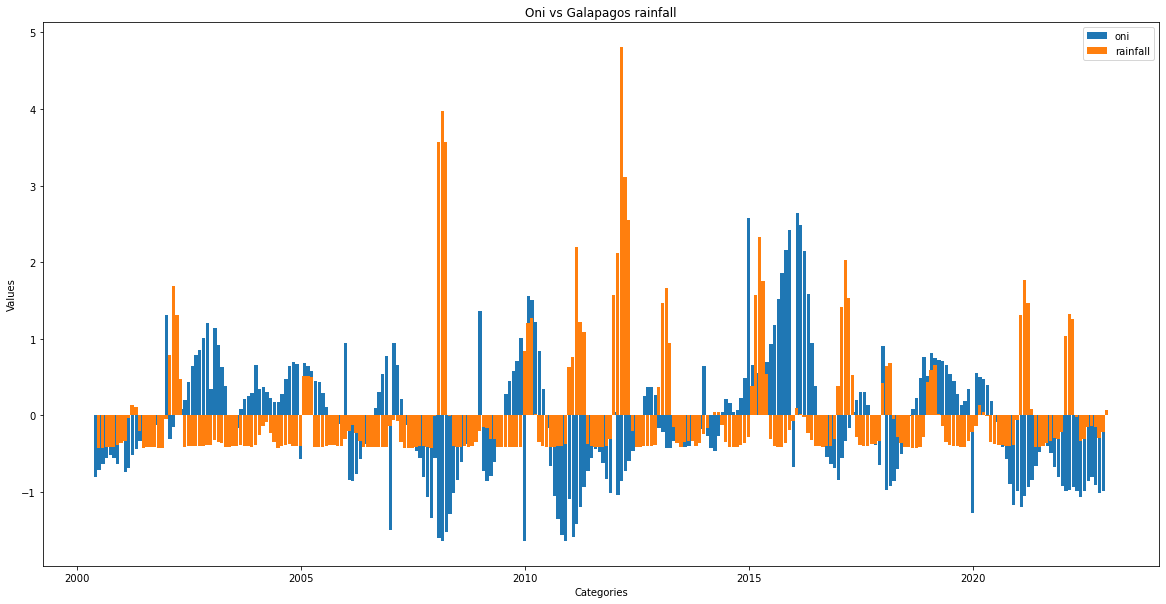

In [46]:
# Plots rainfall and ONI data as time series.

plt.figure(figsize=(20,10))
plt.bar(x= np.array(result['observation_date'].apply(date_to_decimal_year)), height=x, width=.075, label='oni')
plt.bar(x= np.array(result['observation_date'].apply(date_to_decimal_year)) + .075, height=y, width=.075, label='rainfall')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Oni vs Galapagos rainfall')
plt.legend()

plt.show()